# Time Series Forecasting using ARIMA and SARIMA for 'SINUSITIS' medical claim counts

## Sinusitis is an inflammation, or swelling, of the tissue lining your sinuses. Sinuses are structures inside your face that are normally filled with air. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Read data

In [24]:
disease_data = pd.read_csv(filepath_or_buffer='sinusitis_copy.csv', sep=',', header=0)

In [3]:
disease_data.head(5)

,monthid,sinusitis_claim_count
0,20170101,380
1,20170201,300
2,20170301,226
3,20170401,199
4,20170501,231


## Plot entire dataset

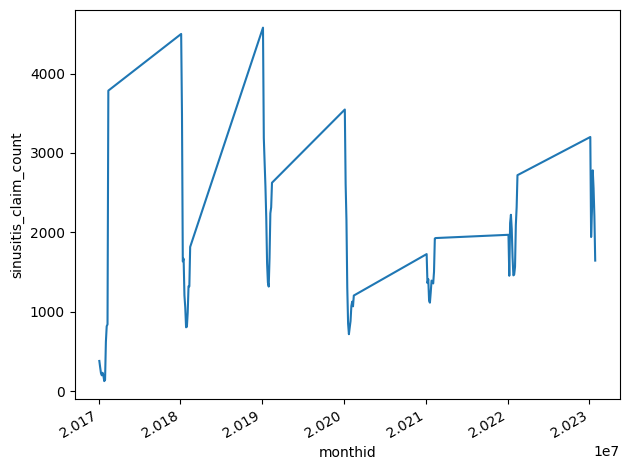

In [4]:
fig, ax = plt.subplots()

ax.plot(disease_data['monthid'], disease_data['sinusitis_claim_count'])
ax.set_xlabel('monthid')
ax.set_ylabel('sinusitis_claim_count')
fig.autofmt_xdate()
plt.tight_layout()

## Above plot shows a seasonal pattern. Let's perform time series decomposition to plot trend, seasonality and residuals.

## Time Series Decomposition of Data

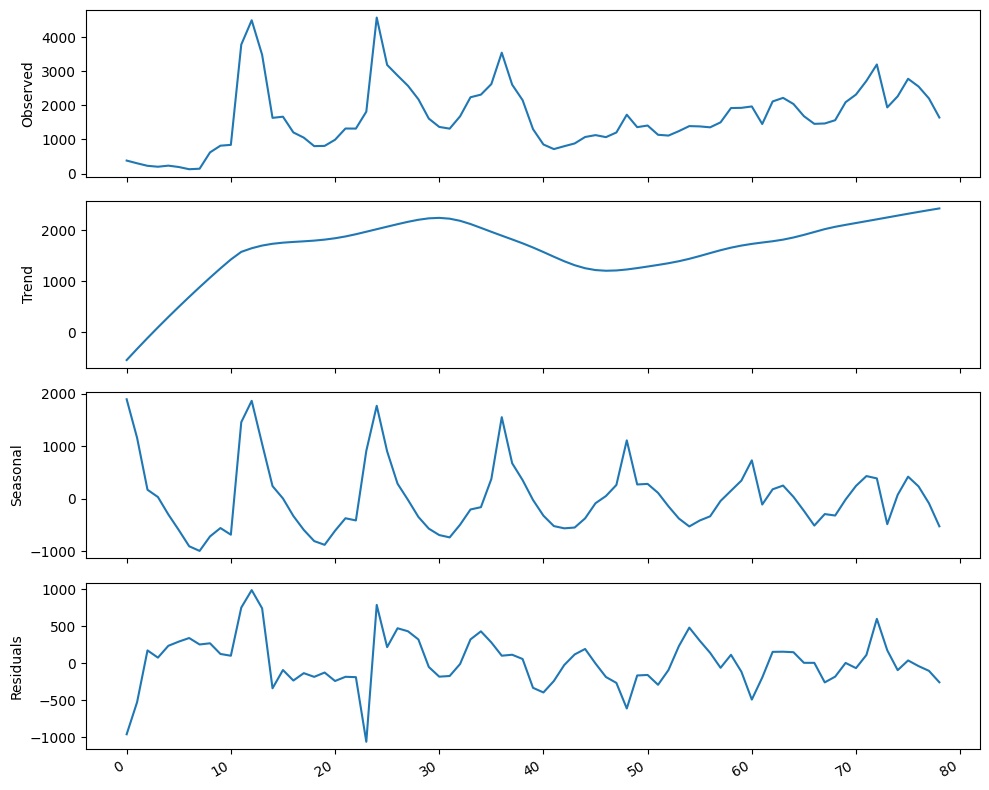

In [5]:
from statsmodels.tsa.seasonal import STL

decomposition = STL(disease_data['sinusitis_claim_count'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## Above plot shows that there is an upward trend. There is also a seasonal pattern

# We will use both ARIMA(p,d,q) & SARIMA(p,d,q)(P,D,Q)m models to verify whether the addition of seasonal components will give better forecasts.

# PART A : Forecasting with ARIMA(p,d,q)

## Is data stationary ?

In [6]:
ADF_result = adfuller(disease_data['sinusitis_claim_count'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.0260570981745814
p-value: 0.7436423470883671


## p-value > 0.05. That means, data is not stationary. Find the number of times we need to difference the data to make it stationary. Difference the data and again perform ADF test.

In [7]:
differenced_claim_count = np.diff(disease_data['sinusitis_claim_count'], n=1)

In [8]:
ADF_result = adfuller(differenced_claim_count)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.8570315820916634
p-value: 0.002374841490898796


## p-value < 0.05, so now our data is stationary. That means, it took 1 differencing to make data stationary. So, our value of d = 1.

## Partition data into train and test. Test dataset will contain the last 12 entries i.e. the last year of data.

In [9]:
train = disease_data['sinusitis_claim_count'][:-12]
test = disease_data['sinusitis_claim_count'][-12:]

## Function to be able to run ARIMA and SARIMA for a list of order combinations

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_loop_for_SARIMA(data, list_of_orders, d, D, s):
    results = []

    for ord in list_of_orders:
        try:
            model = SARIMAX(
                            data, 
                            order=(ord[0], d, ord[1]), 
                            seasonal_order=(ord[2], D, ord[3], s),
                            simple_differencing=False).fit(disp=False) 
        except:
            continue

        # Gather value for the Akaike Information Criterion (AIC)
        aic = model.aic
        results.append([ord, aic])

    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,q,P,Q)', 'AIC']

    return results_df

## Define a range of possible values for the parameters p and q and fit all unique ARIMA(p,d,q) models.
## We will go up 12 for both p and q - i.e. allow the AR and MA component to go back 12 steps in time, because our hypothesis that there is a cycle of 12 months in play here.
## The seasonal order will be (0,0,0).

In [11]:
from itertools import product
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings('ignore')


ps = range(0, 13, 1)  # Go back 12 steps in time for AR 
qs = range(0, 13, 1)  # Go back 12 steps in time for MA
Ps = [0]  # because for ARIMA, there is no seasonal component
Qs = [0]  # because for ARIMA, there is no seasonal component

# create every combination of ps, qs, Ps, Qs
order_list_for_ARIMA = list(product(ps, qs, Ps, Qs))

d = 1     # because we had to difference data once
D = 0     # because for ARIMA, there is no seasonal component  
s = 12    # because we have 12 timesteps in a year

result_df_for_ARIMA = run_loop_for_SARIMA(train, order_list_for_ARIMA, d, D, s)

## Sort values by AIC ascending

In [12]:
result_df_for_ARIMA.sort_values(by='AIC', ascending=True).reset_index(drop=True)

,"(p,q,P,Q)",AIC
0,"(2, 3, 0, 0)",12.000000
1,"(2, 1, 0, 0)",1046.420762
2,"(2, 2, 0, 0)",1046.548791
3,"(1, 2, 0, 0)",1046.946074
4,"(11, 2, 0, 0)",1047.396788
...,...,...
163,"(7, 10, 0, 0)",1332.545818
164,"(10, 10, 0, 0)",1374.187960
165,"(9, 10, 0, 0)",1377.839913
166,"(11, 10, 0, 0)",1419.299882


## Fit an ARIMA model for the best p and q values and plot diagnostics 

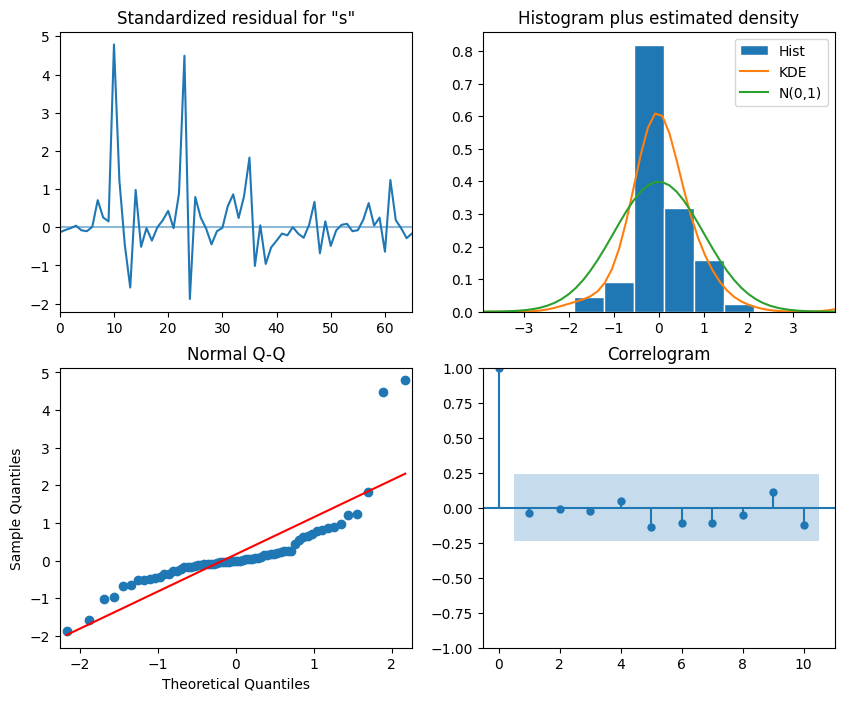

In [13]:
ARIMA_model = SARIMAX(train, order=(2,1,1), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

## Examine residual using Ljungbox test. p-values are all greater than 0.05, so we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.098368,0.753797
2,0.105606,0.948567
3,0.162063,0.983468
4,0.340442,0.987056
5,1.736400,0.884282
6,2.650128,0.851302
7,3.607569,0.823704
8,3.800566,0.874654
9,4.741173,0.856262
10,6.026551,0.813028


## Create test dataframe with last 12 entries. Predict with the ARIMA_model from above and append entries to test alongside the original values.

In [15]:
test = disease_data.iloc[-12:]
ARIMA_pred = ARIMA_model_fit.get_prediction(67, 78).predicted_mean
test['ARIMA_pred'] = ARIMA_pred
test

,monthid,sinusitis_claim_count,ARIMA_pred
67,20220801,1469,1423.586678
68,20220901,1565,1441.743561
69,20221001,2093,1466.844299
70,20221101,2319,1486.657458
71,20221201,2720,1499.857961
72,20230101,3201,1507.952996
73,20230201,1941,1512.679283
74,20230301,2267,1515.350870
75,20230401,2781,1516.826933
76,20230501,2555,1517.628809


# PART B : Forecasting with SARIMA(p,d,q)(P,D,Q)m

In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

# create every combination of ps, qs, Ps, Qs
order_list_for_SARIMA = list(product(ps, qs, Ps, Qs))

d = 1     
D = 1       
s = 12    

result_df_for_SARIMA = run_loop_for_SARIMA(train, order_list_for_SARIMA, d, D, s)

In [17]:
result_df_for_SARIMA.sort_values(by='AIC', ascending=True).reset_index(drop=True)

,"(p,q,P,Q)",AIC
0,"(0, 0, 1, 1)",853.934605
1,"(0, 0, 0, 2)",854.249962
2,"(0, 0, 0, 1)",854.643070
3,"(0, 0, 0, 3)",855.357189
4,"(0, 1, 0, 1)",855.384889
...,...,...
251,"(3, 2, 3, 3)",866.771632
252,"(3, 3, 1, 3)",867.070708
253,"(3, 3, 0, 0)",869.575209
254,"(3, 3, 1, 0)",869.817337


## Fit an SARIMA model for the best p,q,P,Q values and plot diagnostics 

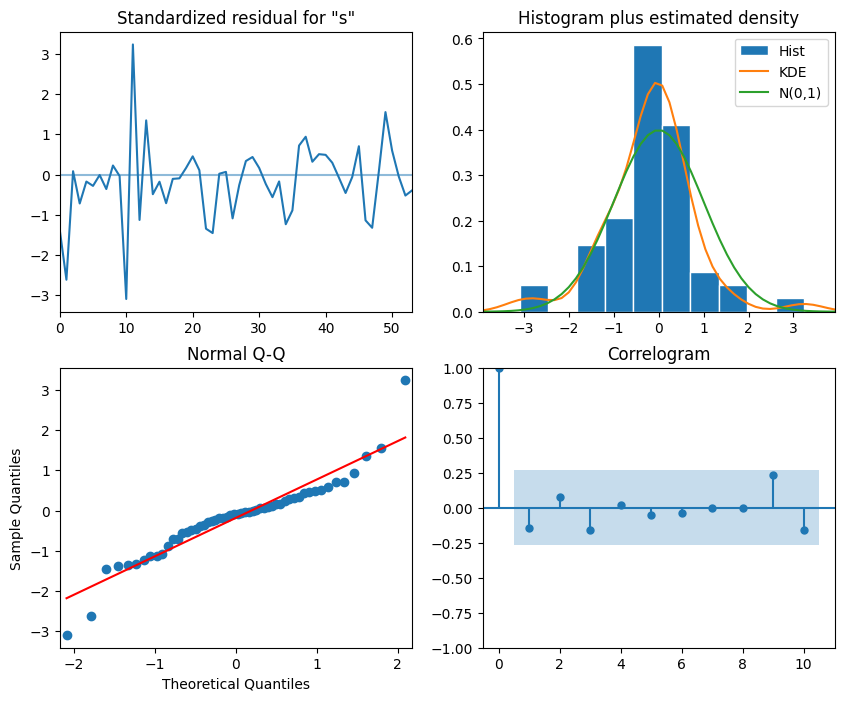

In [18]:
SARIMA_model = SARIMAX(train, order=(0,1,0), seasonal_order=(1,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

## Ljung box test results tell us that the p-values are all greater than 0.05 and hene the residuals are random.

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.197874,0.656442
2,0.256753,0.879522
3,3.347486,0.341088
4,3.399486,0.493325
5,4.109179,0.533806
6,4.348441,0.629634
7,4.350101,0.738684
8,4.350365,0.824210
9,6.057092,0.734191
10,6.770301,0.746937


## Get SARIMA predictions and append the 'test' dataframe

In [20]:
SARIMA_pred = SARIMA_model_fit.get_prediction(67, 78).predicted_mean
test['SARIMA_pred'] = SARIMA_pred
test

,monthid,sinusitis_claim_count,ARIMA_pred,SARIMA_pred
67,20220801,1469,1423.586678,1460.175256
68,20220901,1565,1441.743561,1601.904240
69,20221001,2093,1466.844299,1806.900579
70,20221101,2319,1486.657458,2010.657206
71,20221201,2720,1499.857961,2563.326374
72,20230101,3201,1507.952996,3141.452204
73,20230201,1941,1512.679283,2540.449931
74,20230301,2267,1515.350870,2580.201080
75,20230401,2781,1516.826933,2489.276576
76,20230501,2555,1517.628809,2283.277231


## Function to calculate Mean Average Percentage Error

In [21]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mape_ARIMA = mape(test['sinusitis_claim_count'], test['ARIMA_pred'])
mape_SARIMA = mape(test['sinusitis_claim_count'], test['SARIMA_pred'])
print(mape_ARIMA, mape_SARIMA)

29.548095049801454 10.567821079483501


## Above we see the SARIMA model (which takes into consideration the seasonality) has a lower mean average percentage error.